In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import igraph as ig
import scipy
from src import renormalizable_model, network_properties
from tqdm import tqdm
from joblib import Parallel, delayed, cpu_count
import matplotlib.pyplot as plt

In [3]:
weighted_adj_matrix = np.loadtxt(open("data/fg_empiricalNTW(node_num=1000).csv", "rb"), delimiter=",").reshape((1000,1000))

In [4]:
strength_data = np.loadtxt(open("data/fg_strengths(node_num=1000).csv", "rb"), delimiter=",")

In [5]:
sampled_out_strengths, sampled_in_strengths, ext_equities = strength_data

In [6]:
out_strengths = np.sum(weighted_adj_matrix, axis=1)
in_strengths = np.sum(weighted_adj_matrix, axis=0)
equities = np.array([np.sum(weighted_adj_matrix[i,:]) - np.sum(weighted_adj_matrix[:,i]) + ext_equities[i] for i in range(len(weighted_adj_matrix))])
leverage_matrix = weighted_adj_matrix/equities[:,None]

In [7]:
synthetic_graph = ig.Graph.Weighted_Adjacency(weighted_adj_matrix)

In [11]:
computed_strengths = np.stack([out_strengths, in_strengths], axis=1)
ensemble_size = 100

### Synthetic network properties

In [8]:
print("Number of edges is:", synthetic_graph.ecount())

Number of edges is: 7076


In [9]:
degrees = synthetic_graph.degree()
print("Number of isolated nodes is:", degrees.count(0))

Number of isolated nodes is: 0


In [46]:
print("Maximal degree is:", np.max(degrees))

Maximal degree is: 503


In [40]:
original_annd_out, original_annd_k_out = network_properties.annd(synthetic_graph, mode="out")

/Volumes/Datový disk/FJFI/Leiden/Research/Renormalization-Network-Reconstruction/src/network_properties.py:19: RuntimeWarning: invalid value encountered in divide
  annd_k = annd_k/degree_hist


### RM network properites

In [13]:
num_of_links = np.sum(weighted_adj_matrix > 0)

In [14]:
def exp_num_of_links(z):
    return np.sum([1 - np.exp(-z*x_i*y_j) for x_i, y_j in np.array(np.meshgrid(out_strengths,in_strengths)).T.reshape(-1, 2)]) - num_of_links

In [15]:
exp_z_details = scipy.optimize.root_scalar(exp_num_of_links, method="bisect", bracket=[0,100])
print(exp_z_details)
exp_z = exp_z_details.root

      converged: True
           flag: converged
 function_calls: 48
     iterations: 46
           root: 0.019080723824060897


In [33]:
ensemble = renormalizable_model.generate_RM_ensemble(500, computed_strengths, exp_z)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [01:07<00:00,  7.43it/s]


In [34]:
print("Average number of edges is:", np.mean([graph.ecount() for graph in ensemble]))

Average number of edges is: 7076.958


In [35]:
avg_is_nodes = np.mean([graph.degree().count(0) for graph in ensemble])
print("Average number of isolated nodes in the ensemble is", avg_is_nodes)

Average number of isolated nodes in the ensemble is 288.924


In [48]:
print("Average maximal degree is:", np.mean([np.max(graph.degree()) for graph in ensemble]))

Average maximal degree is: 524.336


#### ANND

In [36]:
def compute_property(graph, property, mode):
    return eval(f"graph.{property}(mode='{mode}')") if mode is not None else eval(f"graph.{property}()")

In [ ]:
ens_annd_out = Parallel(n_jobs=cpu_count())(delayed(compute_property)(graph, "annd", mode="out") for graph in tqdm(ensemble))

In [38]:
avg_ens_annd_out = np.nanmean(ens_annd_out, axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_68164/2198922203.py:1: RuntimeWarning: Mean of empty slice
  avg_ens_annd_out = np.nanmean(ens_annd_out, axis=0)


Text(0, 0.5, '$\\langle ANND_{out}\\rangle$')

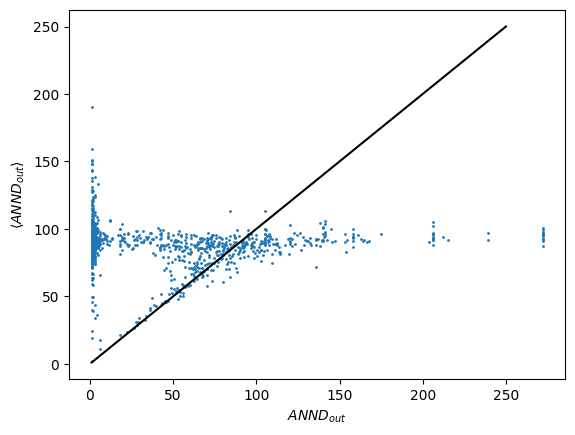

In [41]:
plt.plot([1,250], [1, 250], c="black")
plt.scatter(original_annd_out, avg_ens_annd_out, s=1)
plt.xlabel(r"$ANND_{out}$")
plt.ylabel(r"$\langle ANND_{out}\rangle$")

#### ANND compared with one graph from ensemble

Text(0, 0.5, '$\\langle ANND_{out}\\rangle$')

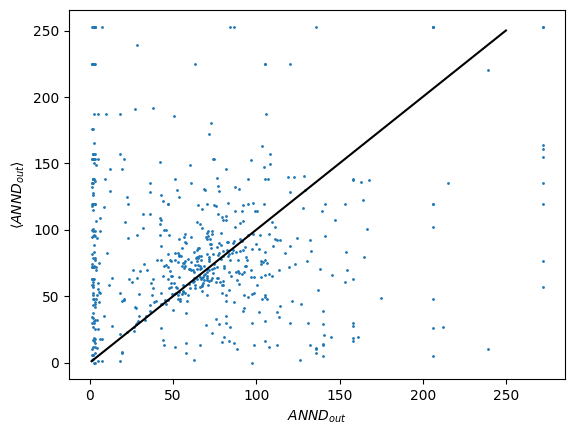

In [80]:
plt.plot([1,250], [1, 250], c="black")
plt.scatter(original_annd_out, ens_annd_out[0], s=1)
plt.xlabel(r"$ANND_{out}$")
plt.ylabel(r"$\langle ANND_{out}\rangle$")

In [58]:
exp_annd_out = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in ensemble], axis=0)

/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Volumes/Datový disk/FJFI/Leiden/Research/Renormalization-Network-Reconstruction/src/network_properties.py:19: RuntimeWarning: invalid value encountered in divide
  annd_k = annd_k/degree_hist
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_68164/1729075400.py:1: RuntimeWarning: Mean of empty slice
  exp_annd_out = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in ensemble], axis=0)


/Volumes/Datový disk/FJFI/Leiden/Research/Renormalization-Network-Reconstruction/src/network_properties.py:19: RuntimeWarning: invalid value encountered in divide
  annd_k = annd_k/degree_hist


Text(0, 0.5, '$k^{nn}_{out}$')

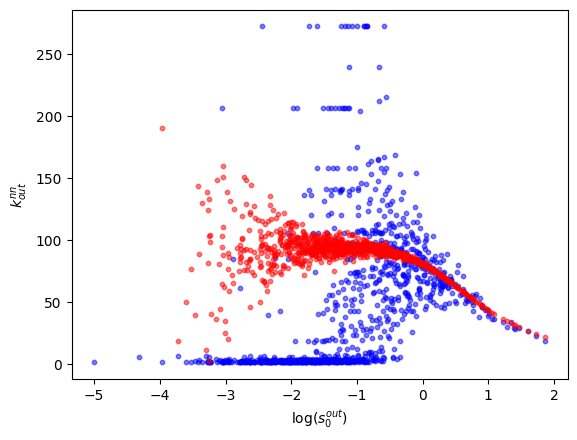

In [60]:
plt.scatter(np.log10(out_strengths), network_properties.annd(synthetic_graph, mode="out")[0], s=10, c="blue", alpha=.5)
plt.scatter(np.log10(out_strengths), exp_annd_out, c="red", s=10, alpha=.5)
plt.xlabel(r"$\log(s_0^{out})$")
plt.ylabel(r"$k^{nn}_{out}$")

### Degree corrected RM properties

In [16]:
degree_corrected_ensemble = renormalizable_model.generate_RM_ensemble(500, computed_strengths, exp_z, degree_corrected=True, parallel=True)

100%|██████████| 500/500 [01:04<00:00,  7.77it/s]


In [17]:
print("Average number of edges is:", np.mean([graph.ecount() for graph in degree_corrected_ensemble]))

Average number of edges is: 7545.552


In [18]:
avg_is_nodes_degree_corrected = np.mean([graph.degree().count(0) for graph in degree_corrected_ensemble])
print("Average number of isolated nodes in the ensemble is", avg_is_nodes_degree_corrected)

Average number of isolated nodes in the ensemble is 115.982


In [49]:
print("Average maximal degree is:", np.mean([np.max(graph.degree()) for graph in degree_corrected_ensemble]))

Average maximal degree is: 565.63


In [43]:
degree_corrected_ens_annd_out = Parallel(n_jobs=cpu_count())(delayed(compute_property)(graph, "annd", mode="out") for graph in tqdm(degree_corrected_ensemble))

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:06<00:00, 75.63it/s]


In [44]:
avg_degree_corrected_ens_annd_out = np.nanmean(degree_corrected_ens_annd_out, axis=0)

Text(0, 0.5, '$\\langle ANND_{out}\\rangle$')

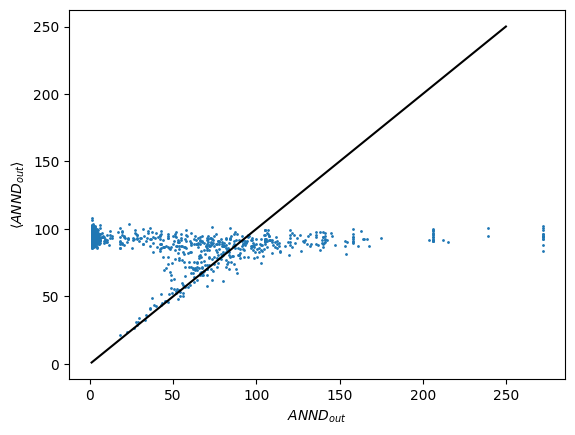

In [45]:
plt.plot([1,250], [1, 250], c="black")
plt.scatter(original_annd_out, avg_degree_corrected_ens_annd_out, s=1)
plt.xlabel(r"$ANND_{out}$")
plt.ylabel(r"$\langle ANND_{out}\rangle$")

In [61]:
exp_degree_corrected_annd_out = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in degree_corrected_ensemble], axis=0)

/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Volumes/Datový disk/FJFI/Leiden/Research/Renormalization-Network-Reconstruction/src/network_properties.py:19: RuntimeWarning: invalid value encountered in divide
  annd_k = annd_k/degree_hist


Text(0, 0.5, '$k^{nn}_{out}$')

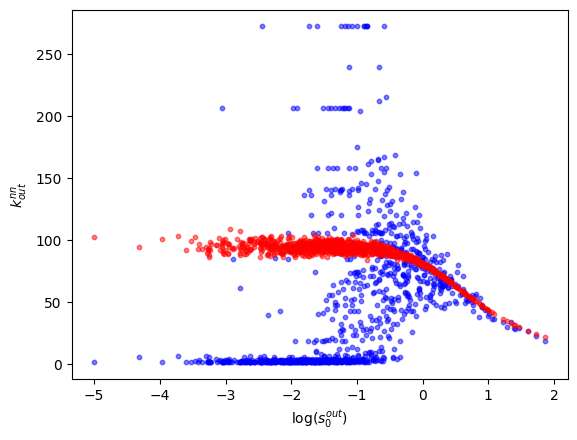

In [62]:
plt.scatter(np.log10(out_strengths), network_properties.annd(synthetic_graph, mode="out")[0], s=10, c="blue", alpha=.5)
plt.scatter(np.log10(out_strengths), exp_degree_corrected_annd_out, c="red", s=10, alpha=.5)
plt.xlabel(r"$\log(s_0^{out})$")
plt.ylabel(r"$k^{nn}_{out}$")

#### Fit z separately

In [75]:
W = np.sum(out_strengths)
def exp_degree_corrected_num_of_links(z):
    return np.sum([(1 - np.exp(-z*x_i*y_j))/(1-np.exp(-z*x_i*W)) for x_i, y_j in np.array(np.meshgrid(out_strengths,in_strengths)).T.reshape(-1, 2)]) - num_of_links

In [79]:
exp_degree_corrected_z_details = scipy.optimize.root_scalar(exp_degree_corrected_num_of_links, method="newton", bracket=[0,100], x0=1)
print(exp_degree_corrected_z_details)
exp_degree_corrected_z = exp_degree_corrected_z_details.root

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_68164/2583869215.py:3: RuntimeWarning: overflow encountered in exp
  return np.sum([(1 - np.exp(-z*x_i*y_j))/(1-np.exp(-z*x_i*W)) for x_i, y_j in np.array(np.meshgrid(out_strengths,in_strengths)).T.reshape(-1, 2)]) - num_of_links
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_68164/2583869215.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum([(1 - np.exp(-z*x_i*y_j))/(1-np.exp(-z*x_i*W)) for x_i, y_j in np.array(np.meshgrid(out_strengths,in_strengths)).T.reshape(-1, 2)]) - num_of_links
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_68164/2583869215.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([(1 - np.exp(-z*x_i*y_j))/(1-np.exp(-z*x_i*W)) for x_i, y_j in np.array(np.meshgrid(out_strengths,in_strengths)).T.reshape(-1, 2)]) - num_of_links


      converged: False
           flag: convergence error
 function_calls: 100
     iterations: 50
           root: nan


In [70]:
degree_corrected_ensemble_2 = renormalizable_model.generate_RM_ensemble(500, computed_strengths, exp_degree_corrected_z, degree_corrected=True, parallel=True)

100%|██████████| 500/500 [01:14<00:00,  6.69it/s]


In [72]:
print("Average number of edges is:", np.mean([graph.ecount() for graph in degree_corrected_ensemble_2]))

Average number of edges is: 66052.412


In [ ]:
avg_is_nodes_degree_corrected_2 = np.mean([graph.degree().count(0) for graph in degree_corrected_ensemble_2])
print("Average number of isolated nodes in the ensemble is", avg_is_nodes_degree_corrected_2)

In [ ]:
print("Average maximal degree is:", np.mean([np.max(graph.degree()) for graph in degree_corrected_ensemble_2]))

In [ ]:
degree_corrected_ens_annd_out_2 = Parallel(n_jobs=cpu_count())(delayed(compute_property)(graph, "annd", mode="out") for graph in tqdm(degree_corrected_ensemble_2))

In [ ]:
avg_degree_corrected_ens_annd_out = np.nanmean(degree_corrected_ens_annd_out, axis=0)
plt.plot([1,250], [1, 250], c="black")
plt.scatter(original_annd_out, avg_degree_corrected_ens_annd_out, s=1)
plt.xlabel(r"$ANND_{out}$")
plt.ylabel(r"$\langle ANND_{out}\rangle$")
exp_degree_corrected_annd_out = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in degree_corrected_ensemble], axis=0)
plt.scatter(np.log10(out_strengths), network_properties.annd(synthetic_graph, mode="out")[0], s=10, c="blue", alpha=.5)
plt.scatter(np.log10(out_strengths), exp_degree_corrected_annd_out, c="red", s=10, alpha=.5)
plt.xlabel(r"$\log(s_0^{out})$")
plt.ylabel(r"$k^{nn}_{out}$")